# Neural Networks Project
Neural Networks course at Sapienza University of Rome
## Augmenting Convolutional networks with Attention-based Aggregation for Image Classification and Breast Cancer Detection

*   Filippo Betello 1835108 
*   Federico Carmignani 1845479

The implementation is using <b>PyTorch</b> (https://pytorch.org/docs/stable/index.html): PyTorch is an optimized Deep Learning tensor library based on Python and Torch and is mainly used for applications using GPUs and CPUs. PyTorch is favored over other Deep Learning frameworks like TensorFlow and Keras since it uses dynamic computation graphs and is completely Pythonic. <br> 
The <b>'PatchConvNet'</b> architecture is tested in <b>Image Classification</b> using the dataset <b>CIFAR10</b> and then it is experimentally applied to <b>Breast Cancer Detection</b>. 
In both cases this architecture is compared with the popular <b>ResNet50</b> architecture for comparisons in both complexity and performances.<br>
The project is inspired to this paper: https://arxiv.org/pdf/2112.13692.pdf



In this notebook we are performing classification on CIFAR10.

## Installation of packages
Timm can be deepened here [Timm](https://github.com/rwightman/pytorch-image-models).<br>
Torch_optimizer can be deepened here [Torch_optimizer](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjxi8T52aL2AhUa_bsIHTirASQQFnoECBIQAQ&url=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Foptim.html&usg=AOvVaw3obblvWxBDMxjyy_1PNztf).<br>
ViT can be deepened here [ViT](https://github.com/lucidrains/vit-pytorch).

In [1]:
#Timm installation: PyTorch Image Models (timm) is a collection of image models, layers, utilities, optimizers, schedulers, data-loaders / augmentations, and reference training / validation scripts that aim to pull together a wide variety of SOTA models with ability to reproduce ImageNet training results
print("\u001b[31m")
!pip install timm

print("\u001b[31m[OK] Timm package installed successfully")


     |████████████████████████████████| 431 kB 9.7 MB/s 
[OK] Timm package installed successfully


In [2]:
#Torch optimizers installation: torch-optimizer – collection of optimizers for PyTorch compatible with optim module
print("\u001b[31m")
!pip install torch_optimizer

print("\u001b[31m[OK] Torch_optimizer package installed successfully")


     |████████████████████████████████| 61 kB 467 kB/s 
[OK] Torch_optimizer package installed successfully


In [3]:
#Installation of an implementation of Vision Transformer: implementation of Vision Transformer, vision classification with only a single transformer encoder, in Pytorch
print("\u001b[31m")
!pip install vit-pytorch

print("\u001b[31m[OK] ViT package installed successfully")


     |████████████████████████████████| 52 kB 850 kB/s 
[OK] ViT package installed successfully


## Imports of libraries and dependencies 
Here are imported the libraries and dependencies used in the implementation.

In [4]:
#System and data imports
import os #system calls and operations with OS 
import os.path as osp #module that is handy when processing files from different places in the system, it is used for different purposes such as for merging, normalizing and retrieving path names in Python
import json #json data format 
from functools import partial #higher-order functions and operations on callable objects
from typing import Optional, Type, Any, Callable, Union, List #optional types and objects to be used
import cv2 #a great tool for image processing and performing computer vision tasks

#MatPlotLib and Numpy imports
import numpy as np #python library used for working with arrays
import matplotlib.pyplot as plt #cross-platform, data visualization and graphical plotting library for Python and its numerical extension numpy

#Torch imports
import torch #open-source machine learning framework: optimized tensor library primarily used for Deep Learning applications using GPUs and CPUs
import torch.nn as nn #modules and classes for neural networks, more here: https://pytorch.org/docs/stable/nn.html
import torch.optim as optim #a library implementing various optimization algorithms
import torch.nn.functional as F #functions like Pooling, Convolution, NonLinear
from torch import Tensor #tensors
import torch_optimizer as optime #optimizers
from torch.utils.data import Dataset #dataset operations

#TorchVision imports
import torchvision #package consists of popular datasets, model architectures, and common image transformations for computer vision
import torchvision.transforms as transforms #tranformations on images
import torchvision.models as models #models
import torch.optim as optim #optimizations
from torchvision import datasets #dataset operations
from torchvision.datasets.folder import ImageFolder, default_loader #image folders management
from torchvision.transforms.transforms import Resize #resize of images

#Timm imports 
import timm #library from package downloaded above for image models used in the architecture PatchConvNet
from timm.data import create_transform #transformations on images
from timm.models.efficientnet_blocks import SqueezeExcite #Squeeze and Excite block, more here: https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7
from timm.models.layers import DropPath, to_2tuple, trunc_normal_ #other operations for the layers of the network
from timm.models.registry import register_model #model registration

#Image visualization imports
from PIL import Image #library to save downloaded images and work on them
import requests #a simple, yet elegant, HTTP library to download images
from vit_pytorch.recorder import Recorder, find_modules #ViT recorder and modules used for the Visualizer

#Google Colab imports
from google.colab import drive #to mount Drive in Google Colab

print("\u001b[31m[OK] Libraries and dependencies imported successfully")

[OK] Libraries and dependencies imported successfully


## Preparation of the dataset: CIFAR10
Here the dataset is:

1.   downloaded
2.   augmented
3.   splitted in training and test phases using specific dataloaders.


In [5]:
#Building and organizing the dataset (CIFAR10)
def build_dataset_CIFAR10():
    #Creating Transform element for Augmentation of the dataset in Training phase: every time a batch is taken randomized transformations are done for Augmentation.
    #Transforms are common image transformations. They can be chained together using Compose.
    transform_train = transforms.Compose([
                                          transforms.RandomHorizontalFlip(), #flips the image w.r.t horizontal axis
                                          transforms.RandomRotation(10),     #rotates the image to a specified angle
                                          transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #performs actions like zooms, change shear angles
                                          transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #customizes the color params 
                                          #transforms.Resize((224, 224)), #only if extended to 224x224 images
                                          transforms.ToTensor(), 
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] #image = (image - mean[1st parameter]) / std[2nd parameter]: the parameters mean, std are passed as 0.5, 0.5 in your case. This will normalize the image in the range [-1,1]. For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1
                                  
                                         )    
    
    #Creating Transform element for Resize of the dataset in Testing phase
    transform = transforms.Compose([
                                    #transforms.Resize((224, 224)), #only if extended to 224x224 images
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] #image = (image - mean[1st parameter]) / std[2nd parameter]: the parameters mean, std are passed as 0.5, 0.5 in your case. This will normalize the image in the range [-1,1]. For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1
                                  )
    
    #Defining the batch size for training and testing phases: as usual a multiple of 2 is chosen
    batch_size = 64
    
    print("\u001b[31m")

    #Training phase: downloading the Training dataset and creation of the dataloader
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    #Test phase: downloading the test dataset and creation of the dataloader
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False)

    #Returning dataset chunks and loaders for both Training and Testing phase, as well as the batch size defined
    return trainset, trainloader, testset, testloader, batch_size



In [14]:
#Enumerating the 10 classes of the dataset CIFAR10 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#Building and splitting the dataset using the method above
trainset, trainloader, testset, testloader, batch_size = build_dataset_CIFAR10()

print("\u001b[31m[OK] The 10 classes in CIFAR10 are: ", classes)
print("\u001b[31m[OK] Dataset downloaded and splitted successfully")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[OK] The 10 classes in CIFAR10 are:  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
[OK] Dataset downloaded and splitted successfully


## Device configuration
A GPU is usually used to exploit its velocity in image processing, if it is not available in Colab then a CPU is assigned.

In [6]:
#Setting GPU (Cuda) as default device, otherwise CPU is assigned
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\u001b[31mThe device assigned is:")
print(device)
print("\u001b[31m[OK] Device configured successfully")

The device assigned is:
cuda:0
[OK] Device configured successfully


## ResNet50 model
A residual neural network (ResNet) is an artificial neural network (ANN). Residual neural networks utilize skip connections, or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between.
ResNet-50 is a convolutional neural network that is 50 layers deep. As a result, the network has learned rich feature representations for a wide range of images. <br> The network is training using an image input size of 32-by-32. <br>
We are going to use it as a basis for comparison with the innovative architecture PatchConvNet implemented in the following section. <br> Note that this ResNet50 has a value of output features equal to 10 according to CIFAR10. <br>
Below the code is taken from [here](https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html) slightly modified to be applied to CIFAR10. <br>
ResNet-50 model from [here](https://arxiv.org/pdf/1512.03385.pdf).

In [12]:
#Convolutional layers
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation) #2D convolution 3x3 with padding
def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False) #2D convolution 1x1

#Single block of the network
class BasicBlock(nn.Module):
    expansion: int = 1 #expansions in convolutions outplanes or other parameters

    def __init__(
        self, #self object
        inplanes: int, #inplanes in convolutions
        planes: int, #outplanes in convolutions
        stride: int = 1, #stride value
        downsample: Optional[nn.Module] = None, #the only optional component to reduce the dimensions
        groups: int = 1,  #no grouped convolutional more than 1
        base_width: int = 64, #used to calculate width of planes in convolution, only 64 accepted
        dilation: int = 1, #no expansion of the kernels
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:

        #Parameters and errors handling
        super(BasicBlock, self).__init__() #constructor
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d  #batch normalization setting
        if groups != 1 or base_width != 64: #errors
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:  #errors
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        
        #Local variable
        self.stride = stride #stride 
        
        #Single block components
        self.conv1 = conv3x3(inplanes, planes, stride) ##convolution3x3 (1)
        self.bn1 = norm_layer(planes) #normalization (2)
        self.relu = nn.ReLU(inplace=True) #ReLu function (3)
        self.conv2 = conv3x3(planes, planes) #convolution3x3 (4)
        self.bn2 = norm_layer(planes) #normalization (5)
        self.downsample = downsample #the only optional component to reduce the dimensions (6)
         
    #Forward method for a single block
    def forward(self, x: Tensor) -> Tensor:
        
        #feeding the network
        identity = x #saving the input
        
        out = self.conv1(x) #(1)
        out = self.bn1(out) #(2)
        out = self.relu(out) #(3)
        
        out = self.conv2(out) #(4)
        out = self.bn2(out) #(5)
        
        if self.downsample is not None: #(6)
            identity = self.downsample(x) 

        out += identity  #residual edge sum
        out = self.relu(out) #last ReLu application

        return out #output of the single block


#Bottleneck is another type of block defined from the previous one
class Bottleneck(nn.Module):
    #Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2) while original implementation places the stride at the first 1x1 convolution(self.conv1).

    expansion: int = 4 #expansions in convolutions outplanes or other parameters

    def __init__(
        self, #self object
        inplanes: int,  #inplanes in convolutions
        planes: int,  #outplanes in convolutions
        stride: int = 1, #stride value
        downsample: Optional[nn.Module] = None, #the optional component to reduce the dimensions
        groups: int = 1, #no grouped convolutional more than 1
        base_width: int = 64, #used to calculate width of planes in convolution, only 64 accepted
        dilation: int = 1,  #no expansion of the kernels
        norm_layer: Optional[Callable[..., nn.Module]] = None  #the optional component for normalization
    ) -> None:
        
        super(Bottleneck, self).__init__() #constructor
        if norm_layer is None: 
            norm_layer = nn.BatchNorm2d #batch normalization is default

        #Width represent the outplanes of first convolution
        width = int(planes * (base_width / 64.)) * groups

        #Bottleneck components
        self.conv1 = conv1x1(inplanes, width) #convolution 1x1 (1)
        self.bn1 = norm_layer(width)  #normalization (2)
        self.conv2 = conv3x3(width, width, stride, groups, dilation) #convolution 3x3 (3)
        self.bn2 = norm_layer(width) #normalization (4)
        self.conv3 = conv1x1(width, planes * self.expansion) #convolution 1x1 (5)
        self.bn3 = norm_layer(planes * self.expansion) #normalization (6)
        self.relu = nn.ReLU(inplace=True) #ReLu function (7)
        self.downsample = downsample #the only optional component to reduce the dimensions (8)
        
        #Local variable
        self.stride = stride #stride

    #Forward method for one bottleneck
    def forward(self, x: Tensor) -> Tensor:
        identity = x #saving the input

        out = self.conv1(x) #(1)
        out = self.bn1(out) #(2)
        out = self.relu(out) #ReLu (7)
        
        out = self.conv2(out) #(3)
        out = self.bn2(out) #(4)
        out = self.relu(out) #ReLu (7)

        out = self.conv3(out) #(5)
        out = self.bn3(out) #(6)

        if self.downsample is not None: #(8)
            identity = self.downsample(x)

        out += identity  #residual edge sum
        out = self.relu(out) #last ReLu application

        return out #output of the single bottleneck


class ResNet(nn.Module):

    def __init__(
        self, #self object
        block: Type[Union[BasicBlock, Bottleneck]], #block 
        layers: List[int], #layers list of int
        num_classes: int = 10, #number of classes (10 for CIFAR10)
        zero_init_residual: bool = False, #initialization of residual
        groups: int = 1, #number of groups
        width_per_group: int = 64, #width of grouped convolution
        replace_stride_with_dilation: Optional[List[bool]] = None, #dilatation in place of stride
        norm_layer: Optional[Callable[..., nn.Module]] = None #normalizations
    ) -> None:

        super(ResNet, self).__init__() #constructor
        
        if norm_layer is None: 
            norm_layer = nn.BatchNorm2d #default batch normalization
        
        #Local variables
        self._norm_layer = norm_layer #normalization
        self.inplanes = 64 #inplanes
        self.dilation = 1 #dilatation value

        #Dilatation if needed and error handling
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        
        #Local variables
        self.groups = groups #groups
        self.base_width = width_per_group #width per group

        #ResNet first (initial) block components
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False) #convolution 7x7 from image RGB (3 input channels)
        self.bn1 = norm_layer(self.inplanes) #normalization
        self.relu = nn.ReLU(inplace=True) #ReLu 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #max pooling

        #Layers (Single blocks or Bottlenecks) after the initial block
        self.layer1 = self._make_layer(block, 64, layers[0]) #block1
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0]) #block2
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1]) #block3
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2]) #block4
        
        #Average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        #Fully connected network 
        self.fc = nn.Linear(512 * block.expansion, num_classes) #output size is 10 (number of classes of CIFAR10)

        #Initializing convolutions and normalizations parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        #Zero-initialize the last BN (Batch Normalization) in each residual branch, so that the residual branch starts with zeros, and each residual block behaves like an identity
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0) 
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  

    #Method to create a layer as Single block or Bottleneck
    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential: #sequential list of blocks
        #Local variables
        norm_layer = self._norm_layer 
        downsample = None
        previous_dilation = self.dilation

        #If dilatation needed in convolution
        if dilate:
            self.dilation *= stride
            stride = 1

        #If parameters changed, downsampling is needed: convolution 1x1 and normalization
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride), 
                norm_layer(planes * block.expansion),
            )
        
        #Layer=list of blocks 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers) #the output is a sequential list of blocks

    #Forward method using the components defined above in the architecture
    def _forward_impl(self, x: Tensor) -> Tensor:
        #Initial block
        x = self.conv1(x) 
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #Layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #Last operations: average pooling and fully connected network feeding
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

#ResNet model
def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs) #model creation
    return model
    
#ResNet50: 48 convolutions + average pooling + fn
def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet: #no pretrained network
    
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs) #bottlenecks are used


In [13]:
#Model creation
model = resnet50()
model = model.to(device)
#Number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("\u001b[31mThe number of parameters in the network is:", count_parameters(model))
print("\u001b[31mModel:\n", model)

The number of parameters in the network is: 23528522
Model:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(

## PatchConvNet model
The architecture and implementation is inspired and taken from this [paper](https://arxiv.org/pdf/2112.13692v1.pdf).
<br> The input images are 32x32 to be applied to CIFAR10 and the patches are 4x4 to have a fine granularity. <br>
The goal is to give visualization properties to convolutional networks augmenting them with an attention map offered by an attention-based layer.
Every patch created is weighted: this procedure is done using a cls_token, which is used for comparison with the other patches, so a difference is computed and the patch having the minor difference will be the one used in the prediction (matrix multiplication has a minor value when the difference is minor and the linear is used to train this layer). The backpropagation helps to change the cls_token trying to reduce this difference with the patches, so the cls_token is learned and when a similar patch will be encountered this will be the "nearest" to the cls_token.
This weights are then used to produce the attention maps.
In order to understand how to modify it for other sizes, convolutions and dimensions of each calculation should be revised, look at this to understand the convolutional rule (https://stackoverflow.com/questions/53580088/calculate-the-output-size-in-convolution-layer).

In [9]:
#Multilayer perceptron network (FFN)
class Mlp(nn.Module): 
    def __init__(
        self,
        in_features: int, 
        hidden_features: Optional[int] = None,
        out_features: Optional[int] = None,
        act_layer: nn.Module = nn.GELU,
        drop: float = 0.0,
    ):
        super().__init__() #constructor

        #Local variable
        out_features = out_features or in_features #out features
        hidden_features = hidden_features or in_features #hidden features

        #Components
        self.fc1 = nn.Linear(in_features, hidden_features) #fc1 (linear)
        self.act = act_layer() #GeLu
        self.fc2 = nn.Linear(hidden_features, out_features) #fc2 (linear)
        self.drop = nn.Dropout(drop)  #dropout (more here (https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html))

    #Forward method with the components above feeded
    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        x = self.fc1(x) 
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


#Learned aggregation layer
class Learned_Aggregation_Layer(nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int = 1,
        qkv_bias: bool = False,
        qk_scale: Optional[float] = None,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ):
        super().__init__() #constructor
        self.num_heads = num_heads #single attention head for S60
        head_dim: int = dim // num_heads #dim=embedded dim=head_dim for S60

        #Scale factor
        self.scale = qk_scale or head_dim**-0.5
        
        #Components
        self.q = nn.Linear(dim, dim, bias=qkv_bias) #linear
        self.k = nn.Linear(dim, dim, bias=qkv_bias) #linear
        self.v = nn.Linear(dim, dim, bias=qkv_bias) #linear
        self.id = nn.Identity() #identity
        self.attn_drop = nn.Dropout(attn_drop) #dropout
        self.proj = nn.Linear(dim, dim) #linear
        self.proj_drop = nn.Dropout(proj_drop)  #dropout

    #Forward method (see the architecture for the structure in the paper)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape  #input shape
        #Linear application q and k and transformation of dimensions and reshape: token cls is passed in Linear and so it learns through learning of it
        q = self.q(x[:, 0]).unsqueeze(1).reshape(B, 1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = self.k(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        #q is scaled
        q = q * self.scale
        #Linear application v
        v = self.v(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        #q and v multiplied
        attn = q @ k.transpose(-2, -1) #@ is matrix multiplication
        #Identity applied
        attn = self.id(attn) #from here the weights of the patches are taken, a hook function is set to be executed here and take the output to create the masks for the attention maps
        #Softmax applied (more here (https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html))
        attn = attn.softmax(dim=-1)
        #Dropout applied
        attn = self.attn_drop(attn)
        #attn and v multiplication
        x_cls = (attn @ v).transpose(1, 2).reshape(B, 1, C)
        #Linear application
        x_cls = self.proj(x_cls)
        #Dropout
        x_cls = self.proj_drop(x_cls)

        return x_cls #the output of the Learned aggregation layer



#Single block additional layer with inside the Learned aggregation layer
class Layer_scale_init_Block_only_token(nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        qk_scale: Optional[float] = None,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: nn.Module = nn.GELU,
        norm_layer=nn.LayerNorm,
        Attention_block=Learned_Aggregation_Layer,
        Mlp_block=Mlp,
        init_values: float = 1e-4,
    ):
        super().__init__() #constructor

        #Components
        self.norm1 = norm_layer(dim) #normalization
        self.attn = Attention_block( #learned aggregation layer
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity() #drop path for stochastic depth
        self.norm2 = norm_layer(dim) #normalization
        mlp_hidden_dim = int(dim * mlp_ratio) #mlp hidden dimension
        self.mlp = Mlp_block(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop) #mlp block
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True) #gamma parameter for drop path
        self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True) #gamma parameter for drop path

    #Forward method feeding the components above
    def forward(self, x: torch.Tensor, x_cls: torch.Tensor) -> torch.Tensor:
        u = torch.cat((x_cls, x), dim=1) 
        x_cls = x_cls + self.drop_path(self.gamma_1 * self.attn(self.norm1(u)))
        x_cls = x_cls + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x_cls))) #in the architecture these are the residual sums at the end of the network
        return x_cls



#Single column/trunk block
class Conv_blocks_se(nn.Module):                              
    def __init__(self, dim: int):
        super().__init__() #constructor

        #Sequential list of convolutions and SE like in the paper is described
        self.qkv_pos = nn.Sequential( 
            nn.Conv2d(dim, dim, kernel_size=1), #convolution 1x1 + GeLu
            nn.GELU(), 
            nn.Conv2d(dim, dim, groups=dim, kernel_size=3, padding=1, stride=1, bias=True), #convolution 3x3 + GeLu
            nn.GELU(),
            SqueezeExcite(dim, rd_ratio=0.25), #SE (more here https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7)
            nn.Conv2d(dim, dim, kernel_size=1),  #convolution 1x1
        )

    #Forward method
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape 
        H = W = int(N ** 0.5) #it depends on the dimensions wanted in the convolutional steps (kernel size, stride etc)
        x = x.transpose(-1, -2)
        x = x.reshape(B, C, H, W)
        x = self.qkv_pos(x) 
        x = x.reshape(B, C, N)
        x = x.transpose(-1, -2) 
        return x                #here the input (output of the ConvStem (2048, 384, 64)) is given to the column and the output will be of the same dimension (reshape) after the operations above are done


#Blocks of column with inside the conv_blocks_se
class Layer_scale_init_Block(nn.Module):
    def __init__(
        self,
        dim: int, #embedded dim
        drop_path: float = 0.0,
        act_layer: nn.Module = nn.GELU,
        norm_layer=nn.LayerNorm,
        Attention_block=None,
        init_values: float = 1e-4,
    ):
        super().__init__() #constructor
        self.norm1 = norm_layer(dim) #normalization
        self.attn = Attention_block(dim) #conv_block_se
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity() #drop path is added for regularization (more here (https://towardsdatascience.com/implementing-stochastic-depth-drop-path-in-pytorch-291498c4a974))
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True) #gamma parameter for DropPath

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))  #here the input tensor is added (residual edge) with the drop_path function created whose parameters are the gamma parameter and the output of the conv_block_se normalized 



#Convolution 3x3 to be used in the network customizing stride and planes
def conv3x3(in_planes: int, out_planes: int, stride: int = 1) -> nn.Sequential:
    """3x3 convolution with padding"""
    return nn.Sequential( 
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False),
    )


#Convolutional stem
class ConvStem(nn.Module):
    """Image to Patch Embedding"""

    def __init__(self, img_size: int = 32, patch_size: int = 4, in_chans: int = 3, embed_dim: int = 768):
        super().__init__() #constructor
        
        img_size = to_2tuple(img_size)     #image size: (32, 32)
        patch_size = to_2tuple(patch_size)    #patch size: (4, 4)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0]) #64 patches (4x4 for 32x32 image)
        
        #Local variables saved from above
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        #Sequential list of convolutions done + GeLu method (auto-feeding by Sequential module)
        #Note that every convolution is done from an input size (in this case 32x32), and the output shape is calculated in this way:
        #output_shape=[(input_size-kernel_size+(2*padding))/stride_value]+1
        #Initial implementation had all 2 as stride values but we needed to change it for CIFAR10 (32x32 images)
        self.proj = nn.Sequential(   
            conv3x3(in_chans, embed_dim // 8, 1),     #convolution 3x3 + GeLu: from (2048, 3, 32, 32) to (2048, embed_dim // 8, output_shape, output_shape) where kernel_size=3, padding=1 and stride is the third parameter of conv3x3 function    
            nn.GELU(),                                #in this case: (2048, 48, 32, 32)
            conv3x3(embed_dim // 8, embed_dim // 4, 1), #convolution 3x3 + GeLu: as above
            nn.GELU(),                                  #in this case: (2048, 96, 32, 32)
            conv3x3(embed_dim // 4, embed_dim // 2, 2), #convolution 3x3 + GeLu: as above
            nn.GELU(),                                  #in this case: (2048, 192, 16, 16)
            conv3x3(embed_dim // 2, embed_dim, 2),  #convolution 3x3 + GeLu: as above
                                                    #in this case: (2048, 384, 8, 8)
        )
    #Forward method
    def forward(self, x: torch.Tensor, padding_size: Optional[int] = None) -> torch.Tensor:
        B, C, H, W = x.shape #(batch_size,rgb_channels,input_size,input_size)=(2048, 3, 32, 32)
        x = self.proj(x) #convolutions are done and the output is (2048, 384, 8, 8) where 384 is the embedded dimension (each patch) 
        x=x.flatten(2) #from (2048, 384, 8, 8) to (2048, 384, 64)
        x=x.transpose(1, 2) #from (2048, 384, 64) to (2048, 64, 384) 
        return x #(2048, 64, 384): for each batch of 2048 images 64 vectors of size 384 are created representing the patches

#The network
class PatchConvnet(nn.Module):

    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=384, depth=60,
                 num_heads=1, qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm, global_pool=None,
                 block_layers = Layer_scale_init_Block,
                 block_layers_token = Layer_scale_init_Block_only_token,
                 Patch_layer=ConvStem,act_layer=nn.GELU,
                 Attention_block = Conv_blocks_se ,
                dpr_constant=True,init_scale=1e-4,
                Attention_block_token_only=Learned_Aggregation_Layer,
                Mlp_block_token_only= Mlp,
                depth_token_only=1,
                mlp_ratio_clstk = 3.0,
                multiclass=False):
      
        super().__init__() #constructor

        self.multiclass = multiclass #false: no multiclass attention in S60 (extensible to it)
        self.patch_size = patch_size #patch size
        self.num_classes = num_classes #number of classes (10 in CIFAR10)
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        self.patch_embed = Patch_layer(     #convolutional stem
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches #number of patches (64 for patches 4x4 in image 32x32)
        
        if not self.multiclass:             #monoclass --> create only one token for all classes: matrix of zeros of 384 size
            self.cls_token = nn.Parameter(torch.zeros(1, 1, int(embed_dim)))
            
        dpr = [drop_path_rate for i in range(depth)]        #array of zeros of length=depth for "drop path" regularization
            
        self.blocks = nn.ModuleList([           #single blocks (column/trunk) of number=depth=60         
            block_layers(
                dim=embed_dim, drop_path=dpr[i], norm_layer=norm_layer,
                act_layer=act_layer,Attention_block=Attention_block,init_values=init_scale)
            for i in range(depth)])
                    
        
        self.blocks_token_only = nn.ModuleList([            #one additional block only for tokens management (cls_token updated)
            block_layers_token(
                dim=int(embed_dim), num_heads=num_heads, mlp_ratio=mlp_ratio_clstk,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=0.0, norm_layer=norm_layer,
                act_layer=act_layer,Attention_block=Attention_block_token_only,
                Mlp_block=Mlp_block_token_only,init_values=init_scale)
            for i in range(depth_token_only)])
        
        self.norm = norm_layer(int(embed_dim))              #normalization 
        
        self.total_len = depth_token_only+depth             #total length of the network=60+1=61
        
        self.feature_info = [dict(num_chs=int(embed_dim ), reduction=0, module='head')]     #[{'num_chs': 384, 'reduction': 0, 'module': 'head'}] dictionary
        if not self.multiclass:
            self.head = nn.Linear(int(embed_dim), num_classes) if num_classes > 0 else nn.Identity()  #linear transformation from single token of 384 (one patch) to a vector of num_classes size (more here https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
        
        trunc_normal_(self.cls_token, std=.02)             #imported from timm for truncated normalization
        self.apply(self._init_weights)                     #method applied recursively to every submodule for weight initialization

    def _init_weights(self, m):         #initialization of weights in Linear and Normalization
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

#methods used in Visualization of attention maps
    @torch.jit.ignore  
    def no_weight_decay(self):
        return {'cls_token'}  #cls_token

    def get_classifier(self):
        return self.head #classifier
    
    def get_num_layers(self):
        return len(self.blocks) #number of layers
    
    #Forward method and its subfunction
    def forward_features(self, x):
        B = x.shape[0]  #batch size
        x = self.patch_embed(x) #the output is the patches (64 vectors of 384 size)
        cls_tokens = self.cls_token.expand(B, -1, -1) #cls_token for classification is used expanded for the whole batch size
        
        for i , blk in enumerate(self.blocks): #feeding the columns
            x  = blk(x)

        for i , blk in enumerate(self.blocks_token_only): #feeding the additional layer (to update the cls_token) with the cls_token and the output of the columns
            cls_tokens = blk(x,cls_tokens)
        x = torch.cat((cls_tokens, x), dim=1) #concatenation of output of the core network and output of additional layer (in architecture the "+" before FFN)

        x = self.norm(x) #normalization
        
        if not self.multiclass:  #monoclass ---> returned every row and the first column
            return x[:, 0]
        else:                    #only for multiclass=True, extensible to it but not used in S60
            return x[:, :self.num_classes].reshape(B,self.num_classes,-1)

    def forward(self, x):
        B = x.shape[0] #batch size
        x  = self.forward_features(x) #call subfunction above
        if not self.multiclass:
            x = self.head(x) #save head= linear created above to have vector of size num_classes
            return x #the output is the vector of size num_classes giving the distribution of probability (or just values of reference) of the class predicted (the max value)
        else:
            all_results = [] #only for multiclass=True, extensible to it but not used in S60
            for i in range(self.num_classes):
                all_results.append(self.head[i](x[:,i]))
            return torch.cat(all_results,dim=1).reshape(B,self.num_classes)

#The PatchConvNet with depth=60, it is possible to extend it but more power and time needed
def S60(pretrained: bool = False, **kwargs):
    model = PatchConvnet(
        patch_size=4,  #the architecture is constructed to be used with patch_size=4, otherwise the ConvStem convolutions should be modified
        embed_dim=384, #embedded dimension: every patch is represented by a vector of size 384
        depth=60, #depth: number of column/trunk in the network core
        num_heads=1, #attention is done with just one head (one visual attention)
        qkv_bias=True, #query, values and keys for attention
        norm_layer=partial(nn.LayerNorm, eps=1e-6), #normalization
        Patch_layer=ConvStem, #ConvStem is created to output the patches: since patch_size=4 (4x4 pixels) there will be 8*8=64 patches (image is 32x32 from CIFAR10)
        Attention_block=Conv_blocks_se, #internal block: column/trunk
        depth_token_only=1, #additional layer 
        mlp_ratio_clstk=3.0, #multilayer perceptron ratio of cls (classification) token
        **kwargs
    )

    return model #the output is the model
        

In [10]:
#Model creation: depth=60 (also extensible to S120 but more power and time needed)
model = S60()
model = model.to(device)
#Number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
print("\u001b[31mThe number of parameters in the network is:", count_parameters(model))
print("\u001b[31m", model)

The number of parameters in the network is: 24849946
 PatchConvnet(
  (patch_embed): ConvStem(
    (proj): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): GELU()
      (2): Sequential(
        (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (3): GELU()
      (4): Sequential(
        (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (5): GELU()
      (6): Sequential(
        (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      )
    )
  )
  (blocks): ModuleList(
    (0): Layer_scale_init_Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Conv_blocks_se(
        (qkv_pos): Sequential(
          (0): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
          (1): GELU()
          (2): Conv2d(384, 384, kernel_size=(3, 3),

## Optimizers and cost function
Note that the output features of the two networks are 10 so that they can be applied to CIFAR10.<br>
Optimizers:<br>
- Lamb is used for large batch optimization. More details [here](https://arxiv.org/abs/1904.00962). <br>
- SGD optimizer is described [here](https://arxiv.org/pdf/1609.04747.pdf). <br>
- Very bad results for large batch optimization are obtained with [Adam](https://arxiv.org/pdf/1412.6980.pdf).<br>

Cost function:<br>
- Loss criterion used for cost function [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [15]:
criterion = nn.CrossEntropyLoss() 
#optimizer = optime.Lamb(model.parameters(), lr = 3e-3, weight_decay=0.01)
optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum = 0.9, weight_decay=0.01) #uncomment to use SGD
#Bad results with Adam
print("\u001b[31m[OK] Optimizer and criterion set up done")

[OK] Optimizer and criterion set up done


## Mounting drive folders
This job is done to save models pretrained.

In [16]:
print("\u001b[31m")
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/NN/Model/resnet50.pth' #path to the model saved in our drive

print("\u001b[31m[OK] Drive mounted successfully")


Mounted at /content/drive
[OK] Drive mounted successfully


## EarlyStopping
Early stopping is a form of regularization used to avoid overfitting on the training dataset. Early stopping keeps track of the validation loss, if the loss stops decreasing for several epochs in a row the training stops. The EarlyStopping class in is used to create an object to keep track of the validation loss while training a PyTorch model. It will save a checkpoint of the model each time the validation loss decrease. We set the patience argument in the EarlyStopping class to how many epochs we want to wait after the last time the validation loss improved before breaking the training loop.
This because when training a pretrained one, overfitting is possible: training accuracy is greater than validation one.

In [17]:
#Defining EarlyStopping to avoid overfitting during training
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/MyDrive/NN/Model/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        #Local variables to save parameters
        self.patience = patience 
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        #Loss saved
        score = -val_loss
        #Check if the result obtained is improving one and save the model in case
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    #method to save checkpoint model
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

print("\u001b[31m[OK] EarlyStopping defined successfully")

[OK] EarlyStopping defined successfully


## Training and validation
Here we start the training and the validation for our models using the mini-batch approach in multiple epochs.<br>
Loss and accuracy are calculated in both the processes and early stopping is set so that the best model is saved and retrieved.

In [18]:
#Variables used for the plots
print("\u001b[31m")
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

#Initialize the early_stopping object
early_stopping = EarlyStopping(patience=10, verbose=True)

##Transfer learning with fine tuning
#model.load_state_dict(torch.load(PATH))
#model.eval()

for epoch in range(10):  #loop over the dataset multiple times
    #Variables
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    total = 0
    total_val = 0
    
    #Training

    model.train() #prepare for training
    for inputs, labels in trainloader:     #take one batch each step from training set and performing random trasformation for data augmentation
        inputs = inputs.to(device, non_blocking=True) # input to device as our model is running in mentioned device.
        labels = labels.to(device, non_blocking=True) # label to device as our model is running in mentioned device.
        #Forward
        outputs = model(inputs) #the outputs will be an array of tensor elements of size 10 (num_classes) each one representing the output related to a single image 
        loss = criterion(outputs, labels) #setting the loss function: crossentropyloss
        optimizer.zero_grad() #zero the parameter gradients
        #Backward 
        loss.backward()
        #Optimization
        optimizer.step()
        #The index of the maximum of the output features is the predicted class
        _, preds = torch.max(outputs, 1) #returns a namedtuple (values, indices): an array of max values is taken to address the predicted classes
        total += labels.size(0) #number of predictions in one epoch
        running_loss += loss.item() #loss in one epoch
        running_corrects += (preds == labels.data).sum().item() #number of correct predictions in one epoch

    else:

    #Validation

      with torch.no_grad(): #we do not need gradient for validation
        model.eval() #prep model for evaluation
        for val_inputs, val_labels in testloader:   #take one batch each step from test set (no data augmentation)
          
          val_inputs = val_inputs.to(device) #input to device as our model is running in mentioned device.
          val_labels = val_labels.to(device) #label to device as our model is running in mentioned device.
          val_outputs = model(val_inputs) #the outputs will be an array of tensor elements of size 10 (num_classes) each one representing the output related to a single image 

          val_loss = criterion(val_outputs, val_labels) #setting the loss function: crossentropyloss
          
          _, val_preds = torch.max(val_outputs, 1) #returns a namedtuple (values, indices): an array of max values is taken to address the predicted classes
          total_val +=  val_labels.size(0) #number of predictions in one epoch
          val_running_loss += val_loss.item() #loss in one epoch
          val_running_corrects += (val_preds == val_labels.data).sum().item() #number of correct predictions in one epoch
      
    #Training metrics
    epoch_loss = running_loss/len(trainloader) #loss per epoch
    epoch_acc = 100 * running_corrects/total #accuracy per epoch
    running_loss_history.append(epoch_loss) #appending for displaying 
    running_corrects_history.append(epoch_acc) #appeding for displaying

    #Validation metrics
    val_epoch_loss = val_running_loss/len(testloader) #val loss per epoch
    val_epoch_acc = 100 * val_running_corrects/total_val #val acc per epoch 
    val_running_loss_history.append(val_epoch_loss) #appending for displaying
    val_running_corrects_history.append(val_epoch_acc) #appending for displaying
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc))
    
    #Early_stopping needs the validation loss to check if it has decresed, and if it has, it will make a checkpoint of the current model
    early_stopping(val_epoch_loss, model) 
    if early_stopping.early_stop:
          print("Early stopping")
          break

#Load the last checkpoint with the best model in case of early stopping
model.load_state_dict(torch.load('/content/drive/MyDrive/NN/Model/checkpoint.pt'))

#Save the model 
torch.save(model.state_dict(), PATH)
print("\u001b[31m[OK] Training and validation ended")


epoch : 1
training loss: 2.1795, acc 29.3820 
validation loss: 1.6726, validation acc 41.3400 
Validation loss decreased (inf --> 1.672648).  Saving model ...
epoch : 2
training loss: 1.7037, acc 40.9260 
validation loss: 1.8104, validation acc 46.7500 
EarlyStopping counter: 1 out of 10
epoch : 3
training loss: 1.5269, acc 45.8920 
validation loss: 1.4565, validation acc 50.6300 
Validation loss decreased (1.672648 --> 1.456459).  Saving model ...
epoch : 4
training loss: 1.3889, acc 50.6460 
validation loss: 1.3401, validation acc 53.9800 
Validation loss decreased (1.456459 --> 1.340145).  Saving model ...
epoch : 5
training loss: 1.3029, acc 53.7440 
validation loss: 1.1598, validation acc 58.9800 
Validation loss decreased (1.340145 --> 1.159834).  Saving model ...
epoch : 6
training loss: 1.2254, acc 56.9400 
validation loss: 1.1100, validation acc 62.2000 
Validation loss decreased (1.159834 --> 1.109971).  Saving model ...
epoch : 7
training loss: 1.1457, acc 59.8680 
validati

##Metrics
Here we are plotting the metrics: accuracy and loss, both for training and validation.

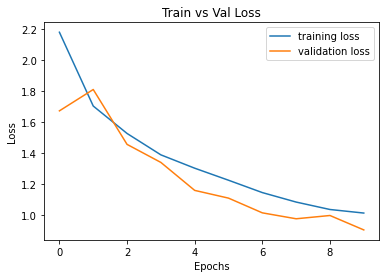

In [19]:
#Plotting loss
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()

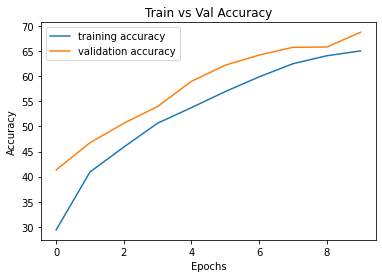

In [20]:
#Plotting accuracy
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()

## Attention maps visualization for PatchConvNet
Visualizer: Slightly modified code from [Lucidrains](https://github.com/lucidrains). <br>
In input there is the model and an image --> in output there is the output of the network (output) + weights of patches in a token (attn).<br>
Here patches 4x4 are used with images 32x32.<br>
Images are downloaded from CIFAR10, transformations are done and the attention maps of a model saved previously are produced.

In [ ]:
#Visualizer from ViT: a model and an image are passed so that the network is feeded and the output is returned, like also the attention map
class visualizer(nn.Module):
   
    def __init__(self, model):
        super().__init__() #constructor
        self.model = model #model saved
        #Variables
        self.data = None 
        self.recordings = [] #this will be the attn token for attention map
        self.hooks = []
        self.hook_registered = False
        self.ejected = False
    
    #It gives the output of the identity in the Learned Aggregation Layer which is then saved in "recordings"
    def _hook(self, _, input, output):
        self.recordings.append(output.clone().detach())

    #Hook method is registered here to be executed when in the Learned Aggregation Layer the identity (id) is calculated
    def _register_hook(self):
        handle = self.model.blocks_token_only[0].attn.id.register_forward_hook(self._hook)
        self.hooks.append(handle)
        self.hook_registered = True

    #Removing all hooks saved
    def eject(self):
        self.ejected = True
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        return self.model

    #Clearing the attn token
    def clear(self):
        self.recordings.clear()

    #Record the attn token
    def record(self, x):
        recording = x.clone().detach()
        self.recordings.append(recording)

    #Forward method of the Visualizer
    def forward(self, img):
        assert not self.ejected, 'recorder has been ejected, cannot be used anymore'
        self.clear() #clear attn token

        if not self.hook_registered:  
            self._register_hook()    #register hook if not done

        pred = self.model(img)       #get output of an image given as input
        return pred, self.recordings  #output of the network and attn token are returned

In [ ]:
#Used to convert rgb into grayscale: 32x32x3 --> 32x32x1
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])  

#Transformations on image 32x32 already in input
def get_transforms(input_size=32, test_size=32,mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]):

    transformations = transforms.Compose(
        [
         #transforms.Resize(int(test_size), interpolation=3),  #to maintain same ratio w.r.t. 32x32 images
         transforms.ToTensor(), #image to tensor
         transforms.Normalize(mean, std)]) #normalizing

    return transformations

In [ ]:
#URL for images to be downloaded from CIFAR10
url_list =[]
url = 'https://huggingface.co/proxy-datasets-preview/assets/cifar10/--/plain_text/train/0/img/image.jpg'
url_list.append(url)
url = 'https://huggingface.co/proxy-datasets-preview/assets/cifar10/--/plain_text/train/3/img/image.jpg'
url_list.append(url)
url = 'https://huggingface.co/proxy-datasets-preview/assets/cifar10/--/plain_text/train/9/img/image.jpg'
url_list.append(url)
url = 'https://huggingface.co/proxy-datasets-preview/assets/cifar10/--/plain_text/train/12/img/image.jpg'
url_list.append(url)
im = [] #images are saved here in an array
for i in range(len(url_list)):
  im.append(Image.open(requests.get(url_list[i], stream=True).raw))
image_size = 32 #image size

In [ ]:
model = S60() #model
PATH = '/content/drive/MyDrive/NN/Model/patch_3e3.pth'
model.load_state_dict(torch.load(PATH))  #model pretrained
model = model.eval() #prepare for validation
#Removing gradients
for p in model.parameters():
    p.requires_grad = False
#Adding visualizer to get the attention map 
model = visualizer(model)

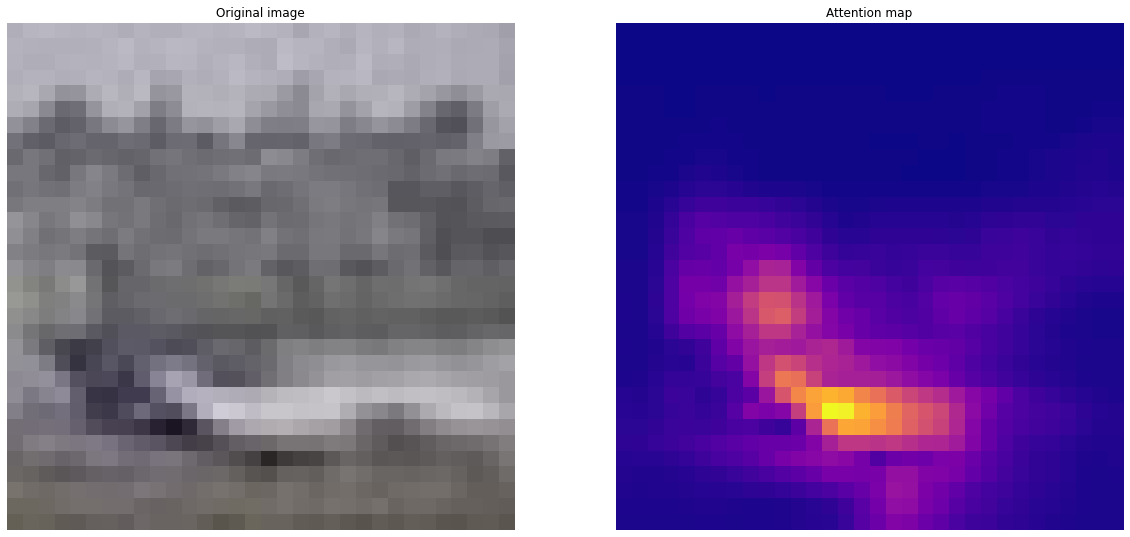

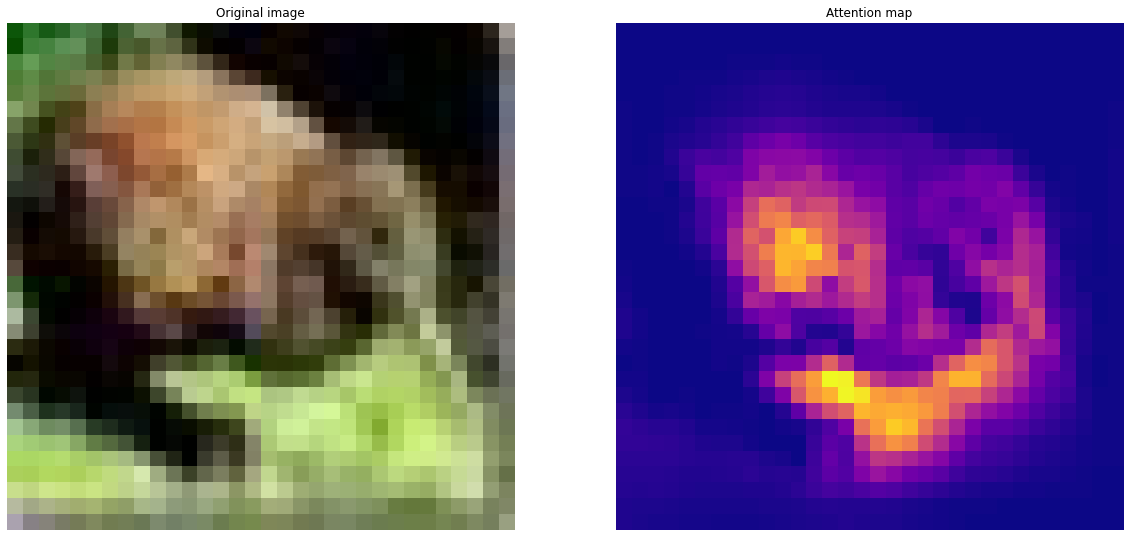

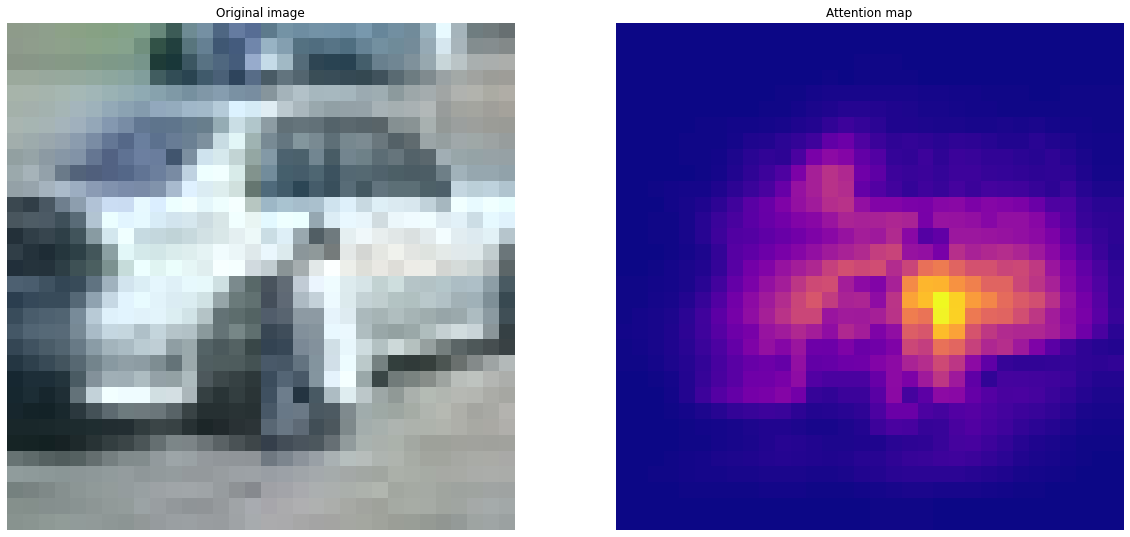

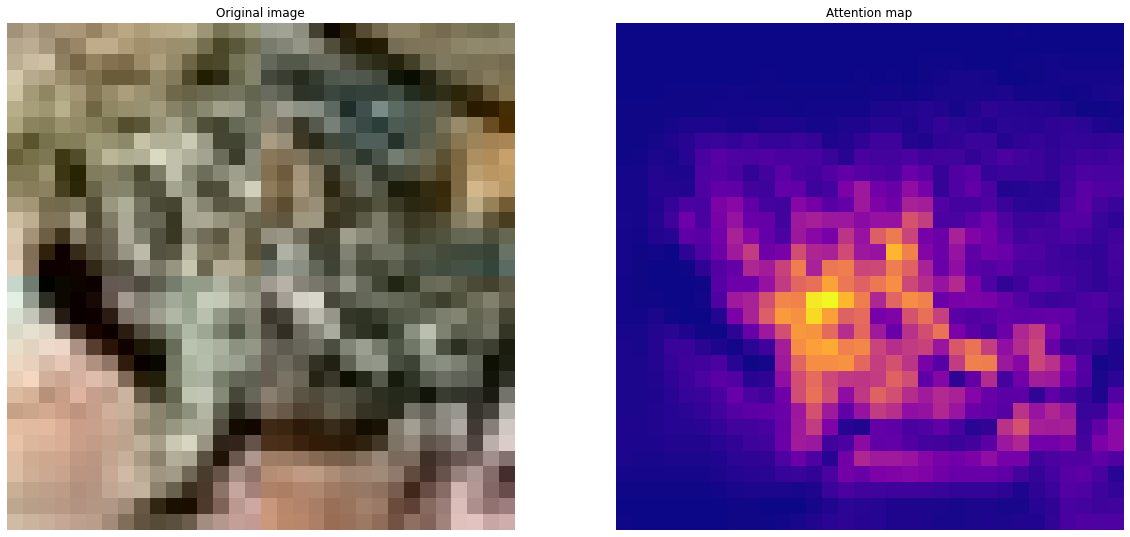

In [ ]:
#Producing attention maps for each image 
for i in range(len(im)): 
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    #Generate sample image
    data_aug = get_transforms(image_size,image_size)
    sample = data_aug(im[i])
    sample = sample.unsqueeze(0)
    #Plot original image
    axs[0].imshow((np.array(1)*im[i]))
    axs[0].grid(None)
    axs[0].axis('off')
    axs[0].set_title('Original image')
    #Get attention maps
    output,attn  = model(sample) #output of the model + attn token
    ps = int(image_size/4) #patches (32/4=8 per row )
    #Softmax score 
    attn2 = attn[0].clone().reshape(ps*ps+1)[1:].softmax(dim=-1).reshape((ps,ps))
    mask = attn2.detach().numpy()
    #Resize attention map to original image size
    mask = cv2.resize(mask/mask.max(), im[i].size)[..., np.newaxis]
    #Normalize attention map
    mask =((mask - mask.min())/(mask.max() - mask.min()))
    result = ((mask) * im[i]).astype("uint8")
    result = rgb2gray(result)
    #Plot attention maps
    axs[1].imshow(result,cmap='plasma') #result is rgb but it is applied to the cmap for colouring
    axs[1].grid(None)
    axs[1].axis('off')
    axs[1].set_title('Attention map')
    plt.show()